# Trends.Earth Global Data Processing - Simplified Version

This notebook submits SDG 15.3.1 indicator jobs to the Trends.Earth API using a grid-based approach.
Each 60-degree grid cell contains multiple 15-degree sub-cells that are submitted together.

## Dependencies
- No GDAL dependencies
- No trends.earth-algorithms dependencies  
- No trends.earth-schemas dependencies
- Uses only: requests, geopandas, rasterio, matplotlib, shapely

In [40]:
import json
import logging
import os
import time
from datetime import datetime, timedelta, timezone
from pathlib import Path
from zoneinfo import ZoneInfo

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import requests
from shapely.geometry import Polygon, mapping

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s.%(msecs)03d %(levelname)s: %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
)

# Configuration
API_URL = "https://api.trends.earth"
LOCAL_TZ = ZoneInfo("America/New_York")
NUM_DAYS = 7  # Number of days to look back for jobs
DOWNLOAD_DIR = Path("C:/Data/TrendsEarth_Global_Data_Tiles")

## Authentication and API Setup

In [41]:
# Load API credentials from JSON file
credentials_file = "trendsearth_api_credentials.json"

try:
    with open(credentials_file, "r") as f:
        creds = json.load(f)

    # Authenticate with API
    auth_url = f"{API_URL}/auth"
    auth_resp = requests.post(auth_url, json=creds)

    if auth_resp.status_code == 200:
        token = auth_resp.json()["access_token"]
        logging.info("✅ Successfully authenticated with Trends.Earth API")
        print(f"API URL: {API_URL}")
        print(f"Username: {creds.get('email', 'N/A')}")
    else:
        logging.error(f"❌ Authentication failed: {auth_resp.status_code}")
        token = None

except FileNotFoundError:
    print(f"❌ Credentials file not found: {credentials_file}")
    print("Please create a JSON file with your API credentials:")
    print('{"email": "your_email@domain.com", "password": "your_password"}')
    token = None
except Exception as e:
    logging.error(f"❌ Error loading credentials: {e}")
    token = None

2025-08-31 22:31:02.167 INFO: ✅ Successfully authenticated with Trends.Earth API


API URL: https://api.trends.earth
Username: trends.earth-prais-server@trends.earth


## Load Job Parameters

Load the SDG 15.3.1 indicator parameters from JSON files

In [5]:
# Load job parameters from JSON files
def load_job_parameters():
    """Load job parameters from JSON files"""
    params = {}

    param_files = {
        "baseline_period": "parameters_sdg-15-3-1-sub-indicators_baseline_te.json",
        "reporting_1": "parameters_sdg-15-3-1-sub-indicators_reporting_1_te.json",
        "reporting_2": "parameters_sdg-15-3-1-sub-indicators_reporting_2_te.json",
    }

    try:
        # Load baseline period
        with open(param_files["baseline_period"], "r") as f:
            params["baseline_period"] = json.load(f)

        # Load reporting periods
        params["status_periods"] = []
        for period in ["reporting_1", "reporting_2"]:
            with open(param_files[period], "r") as f:
                params["status_periods"].append(json.load(f))

        print("✅ Job parameters loaded successfully")
        print(f"Script: {params['baseline_period']['script']}")
        print(
            f"Baseline period: {params['baseline_period'].get('start_year', 'N/A')} - {params['baseline_period'].get('end_year', 'N/A')}"
        )
        print(f"Reporting periods: {len(params['status_periods'])}")

        return params

    except FileNotFoundError as e:
        print(f"❌ Parameter file not found: {e}")
        print("Please ensure the parameter JSON files are in the current directory")
        return None
    except Exception as e:
        print(f"❌ Error loading parameters: {e}")
        return None


job_params = load_job_parameters()

✅ Job parameters loaded successfully
Script: {'additional_configuration': {}, 'slug': 'sdg-15-3-1-indicator-2-1-17', 'description': 'Calculate SDG 15.3.1 indicator in one step', 'id': '3210ba53-4044-4a72-b753-75df89f09424', 'name': 'sdg-15-3-1-indicator', 'name_readable': 'SDG 15.3.1 indicator', 'run_mode': 'remote', 'version': '2.1.17'}
Baseline period: N/A - N/A
Reporting periods: 2


## Create Global Grid System

Generate 60-degree main grid cells, each containing 16 sub-cells of 15 degrees each

In [6]:
# Define grid parameters
MAIN_CELL_SIZE = 60  # degrees - main grid cells
SUB_CELL_SIZE = 15  # degrees - sub-cells within each main grid cell
LON_MIN, LON_MAX = -180, 180
LAT_MIN, LAT_MAX = -90, 90


def create_global_grid():
    """Create global grid with main cells and sub-cells"""
    grid_cells = []
    grid_subcells = {}  # Dictionary to store sub-cells for each grid cell

    grid_index = 0

    for lon in range(LON_MIN, LON_MAX, MAIN_CELL_SIZE):
        for lat in range(LAT_MIN, LAT_MAX, MAIN_CELL_SIZE):
            # Create main 60-degree grid cell
            main_polygon = Polygon(
                [
                    (lon, lat),
                    (lon + MAIN_CELL_SIZE, lat),
                    (lon + MAIN_CELL_SIZE, lat + MAIN_CELL_SIZE),
                    (lon, lat + MAIN_CELL_SIZE),
                ]
            )

            grid_cells.append((main_polygon, f"{grid_index}"))

            # Create 15-degree sub-cells within this 60-degree cell
            sub_cells = []
            for sub_lon in range(lon, lon + MAIN_CELL_SIZE, SUB_CELL_SIZE):
                for sub_lat in range(lat, lat + MAIN_CELL_SIZE, SUB_CELL_SIZE):
                    sub_polygon = Polygon(
                        [
                            (sub_lon, sub_lat),
                            (sub_lon + SUB_CELL_SIZE, sub_lat),
                            (sub_lon + SUB_CELL_SIZE, sub_lat + SUB_CELL_SIZE),
                            (sub_lon, sub_lat + SUB_CELL_SIZE),
                        ]
                    )
                    sub_cells.append(sub_polygon)

            grid_subcells[grid_index] = sub_cells
            grid_index += 1

    return grid_cells, grid_subcells


# Create the grid
grid_cells, grid_subcells = create_global_grid()

print(f"✅ Created {len(grid_cells)} main grid cells of {MAIN_CELL_SIZE}° each")
print(
    f"✅ Each main cell contains {len(grid_subcells[0])} sub-cells of {SUB_CELL_SIZE}° each"
)

✅ Created 18 main grid cells of 60° each
✅ Each main cell contains 16 sub-cells of 15° each


## Visualize Grid System

✅ Using cartopy world boundaries


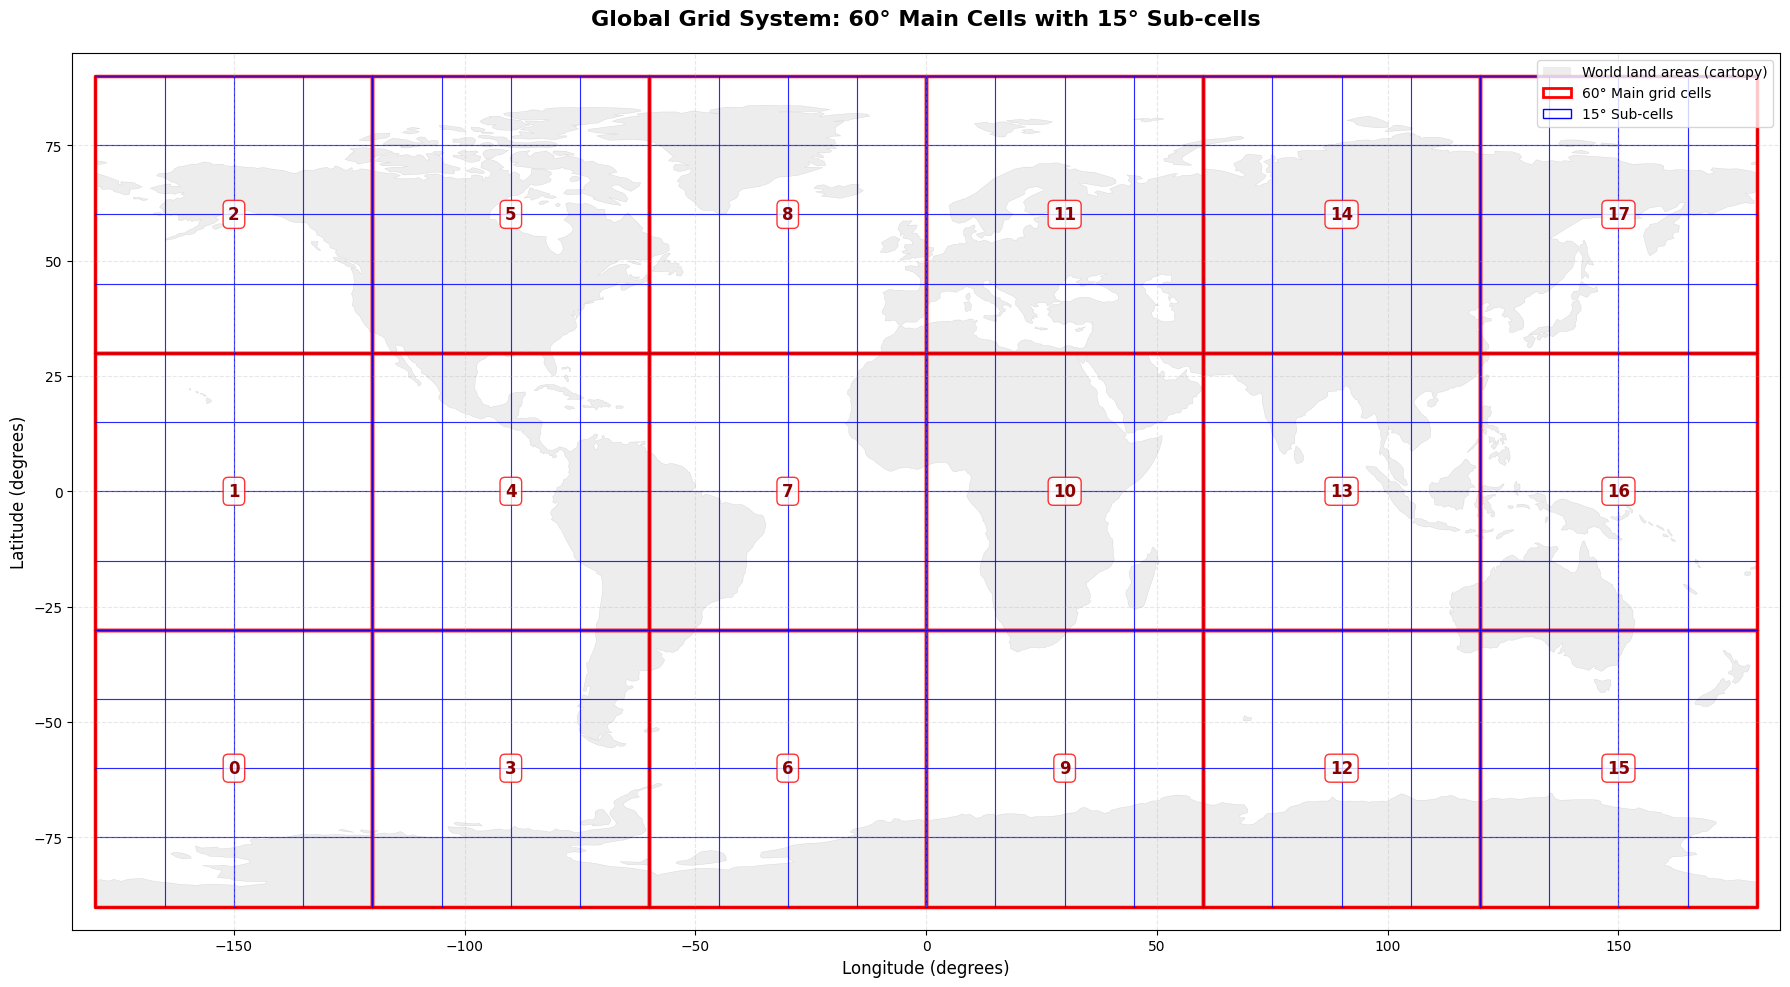

🔴 Red cells: 18 main grid cells (60° each)
🔵 Blue cells: 288 sub-cells (15° each)
🗺️ World boundaries: cartopy land features
📋 Grid indices: Labeled 0-17 within each main cell


In [ ]:
import cartopy.feature as cfeature
from matplotlib.patches import Patch

# Create GeoDataFrames for visualization
grid_gdf = gpd.GeoDataFrame(grid_cells, columns=["geometry", "label"], crs="EPSG:4326")

# Create GeoDataFrame for sub-cells (for visualization)
sub_cell_data = []
for grid_index, sub_cells in grid_subcells.items():
    for i, sub_cell in enumerate(sub_cells):
        sub_cell_data.append((sub_cell, f"{grid_index}_{i}"))

sub_grid_gdf = gpd.GeoDataFrame(
    sub_cell_data, columns=["geometry", "label"], crs="EPSG:4326"
)


# Get world boundaries using cartopy
def get_world_boundaries():
    """Get world boundaries from cartopy"""

    # Get land geometries from cartopy
    land = cfeature.LAND.geometries()

    # Convert to GeoDataFrame
    geoms = list(land)
    world = gpd.GeoDataFrame([{"geometry": geom} for geom in geoms], crs="EPSG:4326")
    print("✅ Using cartopy world boundaries")
    return world


# Get world boundaries
world = get_world_boundaries()

# Plot the map
fig, ax = plt.subplots(figsize=(18, 10))

# Plot world boundaries from cartopy
world.plot(ax=ax, color="lightgray", edgecolor="darkgray", alpha=0.4, linewidth=0.3)

# Plot grid
grid_gdf.plot(ax=ax, edgecolor="red", facecolor="none", linewidth=2.5)
sub_grid_gdf.plot(ax=ax, edgecolor="blue", facecolor="none", linewidth=0.8, alpha=0.6)

# Add enhanced labels to main grid cells
for idx, row in grid_gdf.iterrows():
    centroid = row.geometry.centroid

    # Add white background for better readability
    ax.text(
        centroid.x,
        centroid.y,
        row.label,
        fontsize=12,
        ha="center",
        va="center",
        color="darkred",
        weight="bold",
        bbox=dict(
            boxstyle="round,pad=0.3", facecolor="white", alpha=0.8, edgecolor="red"
        ),
    )

# Enhance the plot appearance
ax.set_title(
    f"Global Grid System: {MAIN_CELL_SIZE}° Main Cells with {SUB_CELL_SIZE}° Sub-cells",
    fontsize=16,
    weight="bold",
    pad=20,
)
ax.set_xlabel("Longitude (degrees)", fontsize=12)
ax.set_ylabel("Latitude (degrees)", fontsize=12)

# Set axis limits and grid
ax.set_xlim(-185, 185)
ax.set_ylim(-95, 95)
ax.grid(True, alpha=0.3, linestyle="--")

legend_elements = [
    Patch(facecolor="lightgray", alpha=0.4, label="World land areas (cartopy)"),
    Patch(
        facecolor="none",
        edgecolor="red",
        linewidth=2,
        label=f"{MAIN_CELL_SIZE}° Main grid cells",
    ),
    Patch(
        facecolor="none",
        edgecolor="blue",
        linewidth=1,
        label=f"{SUB_CELL_SIZE}° Sub-cells",
    ),
]
ax.legend(handles=legend_elements, loc="upper right", fontsize=10)

# Improve tick formatting
ax.tick_params(axis="both", which="major", labelsize=10)

plt.tight_layout()
plt.show()

print(f"🔴 Red cells: {len(grid_gdf)} main grid cells ({MAIN_CELL_SIZE}° each)")
print(f"🔵 Blue cells: {len(sub_grid_gdf)} sub-cells ({SUB_CELL_SIZE}° each)")
print("🗺️ World boundaries: cartopy land features")
print(f"📋 Grid indices: Labeled 0-{len(grid_gdf) - 1} within each main cell")

## Manage jobs

### Setup functions

In [ ]:
def submit_job(geojsons, task_name, token, job_params):
    """Submit a job to the Trends.Earth API"""
    if not token or not job_params:
        print("❌ Missing authentication token or job parameters")
        return False

    # Prepare job parameters
    params = {
        "geojsons": geojsons,
        "baseline_period": job_params["baseline_period"],
        "status_periods": job_params["status_periods"],
        "script": job_params["baseline_period"]["script"],
        "task_name": task_name,
        "task_notes": job_params["baseline_period"].get("task_notes", ""),
        "filetype": job_params["baseline_period"].get("filetype", "tif"),
        "crosses_180th": job_params["baseline_period"].get("crosses_180th", False),
        "crs": job_params["baseline_period"].get("crs", "EPSG:4326"),
    }

    # Submit the job
    try:
        response = requests.post(
            f"{API_URL}/api/v1/script/sdg-15-3-1-indicator-2-1-17/run",
            json=params,
            headers={"Authorization": f"Bearer {token}"},
            timeout=60,
        )

        if response.status_code == 200:
            job_id = response.json().get("data", {}).get("id")
            logging.info(f"✅ Job submitted successfully: {task_name} (ID: {job_id})")
            return job_id
        else:
            logging.error(
                f"❌ Job submission failed: {response.status_code} - {response.text}"
            )
            return False

    except Exception as e:
        logging.error(f"❌ Error submitting job: {e}")
        return False


def convert_subcells_to_geojson(sub_cells):
    """Convert shapely polygons to geojson format"""
    geojsons = []
    for sub_cell in sub_cells:
        geojson = json.loads(json.dumps(mapping(sub_cell)))
        geojsons.append(geojson)
    return geojsons


def get_jobs(token, filter_name=None, days_back=NUM_DAYS):
    """Get jobs from the API, returning only the most recent job for each grid cell"""
    if not token:
        print("❌ No authentication token available")
        return []

    try:
        # Calculate date filter
        now = datetime.now(tz=timezone.utc)
        relevant_date = now - timedelta(days=days_back)

        # Get jobs from API
        response = requests.get(
            f"{API_URL}/api/v1/execution",
            params={"updated_at": relevant_date.strftime("%Y-%m-%d")},
            headers={"Authorization": f"Bearer {token}"},
            timeout=30,
        )

        if response.status_code == 200:
            jobs = response.json()["data"]

            # Filter by name if specified
            if filter_name:
                jobs = [
                    job
                    for job in jobs
                    if filter_name in job.get("params", {}).get("task_name", "")
                ]

            # Group jobs by grid cell and return only the most recent for each grid cell
            if filter_name and "60deg_cell_" in filter_name:
                import re

                # Dictionary to store the most recent job for each grid cell
                grid_cell_jobs = {}

                for job in jobs:
                    task_name = job.get("params", {}).get("task_name", "")

                    # Extract grid cell index from task name using regex
                    # Pattern: sdg_indicator-60deg_cell_{index}_with_{count}_subcells
                    match = re.search(r"60deg_cell_(\d+)_with_", task_name)
                    if match:
                        grid_index = int(match.group(1))

                        # Parse start_date for comparison
                        try:
                            start_date_str = job.get("start_date", "")
                            if start_date_str:
                                # Handle timezone format
                                if start_date_str.endswith("Z"):
                                    start_date_str = start_date_str.replace(
                                        "Z", "+00:00"
                                    )
                                start_date = datetime.fromisoformat(start_date_str)

                                # Keep only the most recent job for this grid cell
                                if grid_index not in grid_cell_jobs:
                                    grid_cell_jobs[grid_index] = (job, start_date)
                                else:
                                    existing_job, existing_date = grid_cell_jobs[
                                        grid_index
                                    ]
                                    if start_date > existing_date:
                                        grid_cell_jobs[grid_index] = (job, start_date)
                        except Exception as date_error:
                            print(
                                f"⚠️ Warning: Could not parse date for job {job.get('id', 'unknown')}: {date_error}"
                            )
                            # If we can't parse the date, still include the job if no other job exists for this grid
                            if grid_index not in grid_cell_jobs:
                                grid_cell_jobs[grid_index] = (
                                    job,
                                    datetime.min.replace(tzinfo=timezone.utc),
                                )

                # Extract just the jobs (not the dates) and sort by grid index
                filtered_jobs = [
                    job_data[0]
                    for grid_index, job_data in sorted(grid_cell_jobs.items())
                ]

                print(
                    f"📊 Filtered to {len(filtered_jobs)} most recent jobs from {len(jobs)} total grid cell jobs"
                )
                return filtered_jobs

            return jobs
        else:
            logging.error(f"❌ Failed to get jobs: {response.status_code}")
            return []

    except Exception as e:
        logging.error(f"❌ Error getting jobs: {e}")
        return []


def print_job_summary(jobs):
    """Print a summary of jobs"""
    if not jobs:
        print("📭 No jobs found")
        return

    # Count by status
    status_counts = {}
    for job in jobs:
        status = job.get("status", "UNKNOWN")
        status_counts[status] = status_counts.get(status, 0) + 1

    print(f"📊 Job Summary ({len(jobs)} total):")
    for status, count in sorted(status_counts.items()):
        emoji = {
            "FINISHED": "✅",
            "RUNNING": "🔄",
            "PENDING": "⏳",
            "FAILED": "❌",
            "READY": "📋",
        }.get(status, "❓")
        print(f"   {emoji} {status}: {count}")


def print_job_details(jobs, max_jobs=20):
    """Print detailed job information"""
    if not jobs:
        return

    print(f"\n📋 Job Details (showing up to {max_jobs}):")

    for i, job in enumerate(jobs[:max_jobs]):
        task_name = job.get("params", {}).get("task_name", "Unknown")
        status = job.get("status", "Unknown")

        start_date = datetime.fromisoformat(job["start_date"].replace("Z", "+00:00"))
        start_str = start_date.astimezone(LOCAL_TZ).strftime("%b %d - %I:%M %p")

        if job.get("end_date"):
            end_date = datetime.fromisoformat(job["end_date"].replace("Z", "+00:00"))
            end_str = end_date.astimezone(LOCAL_TZ).strftime("%b %d - %I:%M %p")
        else:
            end_str = "N/A"

        print(
            f"   {i + 1:2d}. {task_name[:30]:<30} | {status:<10} | {start_str} → {end_str}"
        )


def download_job(job_dict, output_dir, token):
    """Download a completed job - downloads ALL tiles for each raster"""
    if not token:
        print("❌ No authentication token available")
        return None

    job_id = job_dict.get("id")
    task_name = job_dict.get("params", {}).get("task_name", "unknown")
    status = job_dict.get("status")

    if status != "FINISHED":
        print(f"⏳ Job {task_name} is not finished (status: {status})")
        return None

    try:
        output_dir = Path(output_dir)
        output_dir.mkdir(parents=True, exist_ok=True)

        # Extract grid cell number from task name
        # Pattern: sdg_indicator-60deg_cell_{cell_number}_with_{count}_subcells
        import re

        grid_cell_match = re.search(r"60deg_cell_(\d+)_with_", task_name)
        grid_cell_number = grid_cell_match.group(1) if grid_cell_match else "unknown"

        # Get execution results containing download URLs
        response = requests.get(
            f"{API_URL}/api/v1/execution/{job_id}/download-results",
            headers={"Authorization": f"Bearer {token}"},
            timeout=30,
        )

        if response.status_code != 200:
            print(f"❌ Failed to get execution results: {response.status_code}")
            return None

        # Parse the results JSON to extract ALL download URLs
        results_data = response.json()

        print(
            "🔍 Searching for ALL download URLs based on trends.earth-schemas structure..."
        )
        download_urls = []

        # Method 1: Check main URI field (RasterResults.uri)
        if "uri" in results_data and results_data["uri"]:
            uri_obj = results_data["uri"]
            if isinstance(uri_obj, dict) and "uri" in uri_obj and uri_obj["uri"]:
                download_urls.append(("main", uri_obj["uri"]))
                print("📋 Found download URL in main RasterResults URI")

        # Method 2: Check rasters field for ALL Raster/TiledRaster URIs
        if "rasters" in results_data:
            rasters = results_data["rasters"]
            if isinstance(rasters, dict):
                for raster_name, raster_data in rasters.items():
                    if isinstance(raster_data, dict):
                        print(f"🔍 Checking raster '{raster_name}' for all URIs...")

                        # Check the main URI of this raster (Raster.uri or TiledRaster.uri)
                        if "uri" in raster_data and raster_data["uri"]:
                            uri_obj = raster_data["uri"]
                            if (
                                isinstance(uri_obj, dict)
                                and "uri" in uri_obj
                                and uri_obj["uri"]
                            ):
                                download_urls.append(
                                    (f"{raster_name}_main", uri_obj["uri"])
                                )
                                print(f"📋 Found main URI for raster '{raster_name}'")

                        # For TiledRaster, collect ALL tile_uris
                        if "tile_uris" in raster_data and raster_data["tile_uris"]:
                            tile_uris = raster_data["tile_uris"]
                            if isinstance(tile_uris, list):
                                print(
                                    f"🔍 Found {len(tile_uris)} tile URIs for raster '{raster_name}'"
                                )
                                for i, tile_uri in enumerate(tile_uris):
                                    if (
                                        isinstance(tile_uri, dict)
                                        and "uri" in tile_uri
                                        and tile_uri["uri"]
                                    ):
                                        download_urls.append(
                                            (
                                                f"{raster_name}_tile_{i + 1}",
                                                tile_uri["uri"],
                                            )
                                        )
                                        print(
                                            f"   📋 Added tile {i + 1}/{len(tile_uris)} for raster '{raster_name}'"
                                        )

        if not download_urls:
            print("❌ No download URLs found in execution results")
            return None

        print(
            f"📥 Downloading {len(download_urls)} files for grid cell {grid_cell_number}..."
        )

        downloaded_files = []

        for i, (file_identifier, download_url) in enumerate(download_urls):
            # Parse tile number from file_identifier
            tile_match = re.search(r"tile_(\d+)", file_identifier)
            if tile_match:
                tile_number = tile_match.group(1)
                # New naming: TrendsEarth_SDG15.3.1_2000_2023-60deg_cell-{cell_number}-{tile_number}
                output_file = (
                    output_dir
                    / f"TrendsEarth_SDG15.3.1_2000_2023-60deg_cell-{grid_cell_number}-{tile_number}.tif"
                )
            else:
                # Fallback for main files or other formats
                output_file = (
                    output_dir
                    / f"TrendsEarth_SDG15.3.1_2000_2023-60deg_cell-{grid_cell_number}-{file_identifier}.tif"
                )

            # Check if file already exists
            if output_file.exists():
                file_size = output_file.stat().st_size / (1024 * 1024)  # MB
                print(
                    f"   ⏭️ File {i + 1}/{len(download_urls)} already exists: {output_file.name} ({file_size:.1f} MB)"
                )
                downloaded_files.append(output_file)
                continue

            print(
                f"   📥 Downloading file {i + 1}/{len(download_urls)}: {output_file.name}..."
            )
            download_response = requests.get(download_url, stream=True, timeout=300)

            if download_response.status_code == 200:
                # Write file in chunks
                with open(output_file, "wb") as f:
                    for chunk in download_response.iter_content(chunk_size=8192):
                        if chunk:
                            f.write(chunk)

                file_size = output_file.stat().st_size / (1024 * 1024)  # MB
                print(f"   ✅ Downloaded: {output_file.name} ({file_size:.1f} MB)")
                downloaded_files.append(output_file)
            else:
                print(
                    f"   ❌ Download failed for {file_identifier}: {download_response.status_code}"
                )

        if downloaded_files:
            total_size = sum(f.stat().st_size for f in downloaded_files) / (
                1024 * 1024
            )  # MB
            print(
                f"✅ All downloads complete! {len(downloaded_files)} files, {total_size:.1f} MB total"
            )
            return downloaded_files  # Return list of all downloaded files
        else:
            print("❌ No files were downloaded successfully")
            return None

    except Exception as e:
        print(f"❌ Error downloading job: {e}")
        return None


def save_job_metadata(job_dict, output_path):
    """Save job metadata to JSON file"""
    try:
        with open(output_path, "w") as f:
            json.dump(job_dict, f, indent=2, default=str)
        print(f"📄 Metadata saved: {Path(output_path).name}")
        return True
    except Exception as e:
        print(f"❌ Error saving metadata: {e}")
        return False


def get_tiff_files(downloaded_files):
    """Handle downloaded TIFF files - can be a single file or list of files"""
    try:
        # Handle both single file and list of files
        if isinstance(downloaded_files, list):
            all_tiff_files = []
            base_dir = None
            for file_path in downloaded_files:
                if file_path.suffix.lower() in [".tif", ".tiff"]:
                    all_tiff_files.append(file_path)
                    if base_dir is None:
                        base_dir = file_path.parent

            if all_tiff_files:
                print(f"📄 {len(all_tiff_files)} TIFF files ready")
                return base_dir, all_tiff_files
            else:
                return None, []
        else:
            # Single file case
            file_path = downloaded_files
            if file_path.suffix.lower() in [".tif", ".tiff"]:
                print(f"📄 TIFF file ready: {file_path.name}")
                return file_path.parent, [file_path]
            else:
                print(f"⚠️ Unexpected file type: {file_path.suffix}")
                return file_path.parent, [file_path]

    except Exception as e:
        print(f"❌ Error processing files: {e}")
        return None, []

### Submit Jobs for Grid Cells

Submit jobs for selected grid cells. Each job contains all 15-degree sub-cells within a 60-degree main cell.

In [ ]:
# Select which grid cells to process
# Options:
# grid_indices = list(range(0, 6))   # First 6 cells (Americas)
# grid_indices = list(range(6, 12))  # Next 6 cells (Africa/Europe)
# grid_indices = list(range(12, 18)) # Last 6 cells (Asia/Australia)
grid_indices = [0, 1, 2]  # Test with first 3 cells

grid_indices = list(range(0, 18))  # all 18 cells

# Configuration
SUBMIT_JOBS = True  # Set to False to just show what would be submitted
PAUSE_BETWEEN_JOBS = True  # Add random delay between submissions

submitted_jobs = []

if token and job_params:
    print(f"🚀 Starting job submission for {len(grid_indices)} grid cells...")

    for i, grid_index in enumerate(grid_indices):
        # Get the 15-degree sub-cells for this 60-degree grid cell
        sub_cells = grid_subcells[grid_index]

        # Convert to geojson format
        sub_cell_geojsons = convert_subcells_to_geojson(sub_cells)

        # Create task name
        task_name = f"sdg_indicator-60deg_cell_{grid_index}_with_{len(sub_cell_geojsons)}_subcells"

        print(f"\n📋 Job {i + 1}/{len(grid_indices)}: Grid cell {grid_index}")
        print(f"   Task name: {task_name}")
        print(f"   Sub-cells: {len(sub_cell_geojsons)} × {SUB_CELL_SIZE}°")

        if SUBMIT_JOBS:
            # Submit the job
            job_id = submit_job(sub_cell_geojsons, task_name, token, job_params)

            if job_id:
                submitted_jobs.append(
                    {
                        "grid_index": grid_index,
                        "task_name": task_name,
                        "job_id": job_id,
                        "sub_cells_count": len(sub_cell_geojsons),
                    }
                )

            # Add delay between jobs to avoid overwhelming the server
            if PAUSE_BETWEEN_JOBS and i < len(grid_indices) - 1:
                sleep_time = np.abs(np.random.normal(30, 15))  # 30±15 seconds
                print(
                    f"   ⏱️ Waiting {sleep_time:.0f} seconds before next submission..."
                )
                time.sleep(sleep_time)
        else:
            print(
                f"   ℹ️ [DRY RUN] Would submit job with {len(sub_cell_geojsons)} sub-cells"
            )

    if SUBMIT_JOBS:
        print("\n✅ Job submission complete!")
        print(
            f"📊 Successfully submitted: {len(submitted_jobs)}/{len(grid_indices)} jobs"
        )

        if submitted_jobs:
            print("\n📋 Submitted job summary:")
            for job in submitted_jobs:
                print(
                    f"   Grid {job['grid_index']}: {job['job_id']} ({job['sub_cells_count']} sub-cells)"
                )
    else:
        print("\n✅ Dry run complete - no jobs were actually submitted")

else:
    print("❌ Cannot submit jobs: missing authentication token or job parameters")

🚀 Starting job submission for 18 grid cells...

📋 Job 1/18: Grid cell 0
   Task name: sdg_indicator-60deg_cell_0_with_16_subcells
   Sub-cells: 16 × 15°


2025-08-30 22:39:07.486 INFO: ✅ Job submitted successfully: sdg_indicator-60deg_cell_0_with_16_subcells (ID: 3fe5823b-d166-4bbc-b96d-5a6321b0d5ea)


   ⏱️ Waiting 14 seconds before next submission...

📋 Job 2/18: Grid cell 1
   Task name: sdg_indicator-60deg_cell_1_with_16_subcells
   Sub-cells: 16 × 15°

📋 Job 2/18: Grid cell 1
   Task name: sdg_indicator-60deg_cell_1_with_16_subcells
   Sub-cells: 16 × 15°


2025-08-30 22:39:22.277 INFO: ✅ Job submitted successfully: sdg_indicator-60deg_cell_1_with_16_subcells (ID: fb9855c8-cd6d-499b-96c8-6e52569863d4)


   ⏱️ Waiting 22 seconds before next submission...


### Check Job Status

Monitor the status of submitted jobs

In [45]:
# Get grid cell jobs
print("🔍 Fetching grid cell jobs...")

# Get our specific jobs (grid cell jobs) using the filter
grid_jobs = get_jobs(token, filter_name="60deg_cell_", days_back=NUM_DAYS)

print(f"📊 Found {len(grid_jobs)} grid cell jobs")

# Print grid cell job details
if grid_jobs:
    print_job_summary(grid_jobs)
    print_job_details(grid_jobs, max_jobs=10)

    # Store for download later
    jobs = grid_jobs
else:
    print("📭 No grid cell jobs found")
    jobs = []

print("\n✅ Job status check complete")

🔍 Fetching grid cell jobs...
📊 Filtered to 18 most recent jobs from 26 total grid cell jobs
📊 Found 18 grid cell jobs
📊 Job Summary (18 total):
   ✅ FINISHED: 18

📋 Job Details (showing up to 10):
    1. sdg_indicator-60deg_cell_0_wit | FINISHED   | Aug 31 - 08:39 AM → Aug 31 - 10:46 AM
    2. sdg_indicator-60deg_cell_1_wit | FINISHED   | Aug 31 - 08:39 AM → Aug 31 - 04:12 PM
    3. sdg_indicator-60deg_cell_2_wit | FINISHED   | Aug 31 - 08:39 AM → Aug 31 - 11:02 AM
    4. sdg_indicator-60deg_cell_3_wit | FINISHED   | Aug 31 - 08:40 AM → Aug 31 - 12:23 PM
    5. sdg_indicator-60deg_cell_4_wit | FINISHED   | Aug 31 - 08:40 AM → Aug 31 - 08:10 PM
    6. sdg_indicator-60deg_cell_5_wit | FINISHED   | Aug 31 - 08:41 AM → Aug 31 - 02:37 PM
    7. sdg_indicator-60deg_cell_6_wit | FINISHED   | Aug 31 - 08:41 AM → Aug 31 - 11:49 AM
    8. sdg_indicator-60deg_cell_7_wit | FINISHED   | Aug 31 - 08:42 AM → Aug 31 - 01:10 PM
    9. sdg_indicator-60deg_cell_8_wit | FINISHED   | Aug 31 - 08:42 AM → Au

### Download Jobs

In [47]:
# Configuration
MAX_DOWNLOADS = 18  # Limit number of jobs downloaded

# Check if download directory exists and create it if it doesn't
if not DOWNLOAD_DIR.exists():
    DOWNLOAD_DIR.mkdir(parents=True, exist_ok=True)
    print(f"📁 Created download directory: {DOWNLOAD_DIR.resolve()}")
else:
    print(f"📁 Download directory exists: {DOWNLOAD_DIR.resolve()}")

# Get finished jobs
if "jobs" in locals() and jobs:
    finished_jobs = [job for job in jobs if job.get("status") == "FINISHED"]

    print(f"🎯 Found {len(finished_jobs)} finished jobs")

    if finished_jobs:
        print(f"📥 Starting download of up to {MAX_DOWNLOADS} jobs...")
        print(f"📁 Download directory: {DOWNLOAD_DIR}")

        downloaded_files = []
        tiff_files = []

        for i, job in enumerate(finished_jobs[:MAX_DOWNLOADS]):
            task_name = job.get("params", {}).get("task_name", "unknown")
            print(
                f"\n📥 Downloading job {i + 1}/{min(len(finished_jobs), MAX_DOWNLOADS)}: {task_name}"
            )

            # Download the job (now returns list of files)
            job_downloaded_files = download_job(job, DOWNLOAD_DIR, token)

            if job_downloaded_files:
                # downloaded_files is now a list from download_job
                if isinstance(job_downloaded_files, list):
                    downloaded_files.extend(job_downloaded_files)
                else:
                    downloaded_files.append(job_downloaded_files)

                # Save metadata with new naming convention
                # Extract grid cell number from task name
                import re

                grid_cell_match = re.search(r"60deg_cell_(\d+)_with_", task_name)
                grid_cell_number = (
                    grid_cell_match.group(1) if grid_cell_match else "unknown"
                )

                # New metadata naming: TrendsEarth_SDG15.3.1_2000_2023-60deg_cell-{cell_number}-metadata.json
                metadata_file = (
                    DOWNLOAD_DIR
                    / f"TrendsEarth_SDG15.3.1_2000_2023-60deg_cell-{grid_cell_number}-metadata.json"
                )
                save_job_metadata(job, metadata_file)

                # Add to TIFF files list
                _, downloaded_tiffs = get_tiff_files(job_downloaded_files)
                if downloaded_tiffs:
                    tiff_files.extend(downloaded_tiffs)

        print("\n✅ Download complete!")
        print(f"📊 Downloaded: {len(downloaded_files)} files")

        if tiff_files:
            print(f"📊 TIFF files ready: {len(tiff_files)}")
            print(f"📁 TIFF files location: {DOWNLOAD_DIR}")

            # Show first few TIFF files
            print("\n📋 Downloaded TIFF files:")
            for tiff in tiff_files[:5]:
                print(f"   📄 {tiff.name}")
            if len(tiff_files) > 5:
                print(f"   ... and {len(tiff_files) - 5} more")
    else:
        print("⏳ No finished jobs available for download")
        print("💡 Check job status above - jobs may still be running")
else:
    print("❌ No jobs available - run the job status check first")

📁 Download directory exists: C:\Data\TrendsEarth_Global_Data_Tiles
🎯 Found 18 finished jobs
📥 Starting download of up to 18 jobs...
📁 Download directory: C:\Data\TrendsEarth_Global_Data_Tiles

📥 Downloading job 1/18: sdg_indicator-60deg_cell_0_with_16_subcells
🔍 Searching for ALL download URLs based on trends.earth-schemas structure...
🔍 Checking raster 'Int16' for all URIs...
🔍 Found 16 tile URIs for raster 'Int16'
   📋 Added tile 1/16 for raster 'Int16'
   📋 Added tile 2/16 for raster 'Int16'
   📋 Added tile 3/16 for raster 'Int16'
   📋 Added tile 4/16 for raster 'Int16'
   📋 Added tile 5/16 for raster 'Int16'
   📋 Added tile 6/16 for raster 'Int16'
   📋 Added tile 7/16 for raster 'Int16'
   📋 Added tile 8/16 for raster 'Int16'
   📋 Added tile 9/16 for raster 'Int16'
   📋 Added tile 10/16 for raster 'Int16'
   📋 Added tile 11/16 for raster 'Int16'
   📋 Added tile 12/16 for raster 'Int16'
   📋 Added tile 13/16 for raster 'Int16'
   📋 Added tile 14/16 for raster 'Int16'
   📋 Added tile

## Create mosaic

### Setup functions

In [27]:
import subprocess
from pathlib import Path

# Add OSGeo4W GDAL tools to PATH
osgeo_bin = r"C:\OSGeo4W\bin"
if Path(osgeo_bin).exists():
    current_path = os.environ.get("PATH", "")
    if osgeo_bin not in current_path:
        os.environ["PATH"] = f"{osgeo_bin};{current_path}"
        print(f"✅ Added {osgeo_bin} to PATH")
    else:
        print(f"✅ {osgeo_bin} already in PATH")
else:
    print(f"⚠️  Warning: {osgeo_bin} not found. Please install OSGeo4W or GDAL")

# Verify GDAL tools are available
try:
    result = subprocess.run(
        ["gdalbuildvrt", "--help"], capture_output=True, text=True, timeout=10
    )
    if result.returncode == 0:
        print("✅ gdalbuildvrt is available")
    else:
        print("❌ gdalbuildvrt failed")
except FileNotFoundError:
    print("❌ gdalbuildvrt not found in PATH")
except Exception as e:
    print(f"❌ Error checking gdalbuildvrt: {e}")

try:
    result = subprocess.run(
        ["gdal_translate", "--help"], capture_output=True, text=True, timeout=10
    )
    if result.returncode == 0:
        print("✅ gdal_translate is available")
    else:
        print("❌ gdal_translate failed")
except FileNotFoundError:
    print("❌ gdal_translate not found in PATH")
except Exception as e:
    print(f"❌ Error checking gdal_translate: {e}")

print("\n🔧 GDAL PATH configuration complete")

✅ C:\OSGeo4W\bin already in PATH
✅ gdalbuildvrt is available
✅ gdal_translate is available

🔧 GDAL PATH configuration complete


In [ ]:
def create_global_cog_via_vrt(
    input_dir,
    output_dir,
    file_pattern="TrendsEarth_SDG15.3.1_2000_2023-60deg_cell-*.tif",
    validated_files=None,
):
    """Create a global COG using VRT for maximum efficiency"""

    input_path = Path(input_dir)
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)

    # Use validated files if provided, otherwise find all files
    if validated_files:
        tiff_files = [
            f for f in validated_files if "mosaic" not in f.name and "COG" not in f.name
        ]
        print(f"🔍 Using {len(tiff_files)} pre-validated TIFF files")
    else:
        tiff_files = [
            f
            for f in input_path.glob(file_pattern)
            if "mosaic" not in f.name and "COG" not in f.name
        ]
        print(f"🔍 Found {len(tiff_files)} TIFF files to combine")

    if not tiff_files:
        print("❌ No TIFF files available for processing")
        return None

    # Create VRT file path
    vrt_path = output_path / "TrendsEarth_Global_Temp.vrt"
    cog_path = output_path / "TrendsEarth_SDG15.3.1_2000-2023.tiff"

    try:
        # Step 1: Create VRT using rasterio
        print("📋 Step 1: Creating VRT from all TIFF files...")

        import rasterio

        # Open all source datasets
        src_datasets = []
        for tiff_file in tiff_files:
            try:
                src = rasterio.open(tiff_file)
                src_datasets.append(src)
            except Exception as e:
                print(f"⚠️  Warning: Could not open {tiff_file}: {e}")

        print(f"✅ Opened {len(src_datasets)} source files")

        # Get overall bounds
        left = min(src.bounds.left for src in src_datasets)
        bottom = min(src.bounds.bottom for src in src_datasets)
        right = max(src.bounds.right for src in src_datasets)
        top = max(src.bounds.top for src in src_datasets)

        print(f"📍 Global bounds: ({left:.2f}, {bottom:.2f}, {right:.2f}, {top:.2f})")

        # Create VRT using GDAL buildvrt (more efficient for many files)
        print("🔗 Creating VRT using GDAL...")

        # Create file list for GDAL
        file_list_path = output_path / "file_list.txt"
        with open(file_list_path, "w") as f:
            for tiff_file in tiff_files:
                f.write(f"{tiff_file.as_posix()}\n")

        # Build VRT using GDAL command
        vrt_cmd = [
            "gdalbuildvrt",
            "-input_file_list",
            str(file_list_path),
            "-srcnodata",
            "-32768",
            "-vrtnodata",
            "-32768",
            "-overwrite",  # Overwrite existing VRT
            str(vrt_path),
        ]

        print(f"🔧 Running: {' '.join(vrt_cmd)}")
        result = subprocess.run(vrt_cmd, capture_output=True, text=True, timeout=300)

        if result.returncode != 0:
            print(f"❌ GDAL buildvrt failed with return code: {result.returncode}")
            print(f"📄 stdout: {result.stdout}")
            print(f"📄 stderr: {result.stderr}")

            # Check if input files exist
            print("\n🔍 Debugging VRT creation:")
            print(f"   File list exists: {file_list_path.exists()}")
            if file_list_path.exists():
                with open(file_list_path, "r") as f:
                    lines = f.readlines()
                print(f"   File list contains {len(lines)} entries")
                print("   First few files:")
                for i, line in enumerate(lines[:3]):
                    file_path = Path(line.strip())
                    exists = file_path.exists()
                    print(
                        f"     {i + 1}. {file_path.name} - {'✅' if exists else '❌'}"
                    )

            return None
        else:
            print(f"✅ Created VRT with GDAL: {vrt_path}")

            # Verify VRT was created properly
            if not vrt_path.exists():
                print(f"❌ VRT file not found after creation: {vrt_path}")
                return None

            vrt_size = vrt_path.stat().st_size
            if vrt_size == 0:
                print(f"❌ VRT file is empty: {vrt_path}")
                return None

            print(f"✅ VRT created successfully: {vrt_size} bytes")

        # Close source datasets
        for src in src_datasets:
            src.close()

        # Step 2: Convert VRT to COG
        print("\n📋 Step 2: Converting VRT to COG...")

        if cog_path.exists():
            file_size = cog_path.stat().st_size / (1024 * 1024 * 1024)  # GB
            print(f"⏭️  COG already exists: {cog_path.name} ({file_size:.2f} GB)")
            return cog_path

        # Use GDAL translate to create COG with enhanced error handling
        cog_cmd = [
            "gdal_translate",
            "-of",
            "COG",
            "-co",
            "COMPRESS=DEFLATE",
            "-co",
            "BIGTIFF=YES",
            "-co",
            "BLOCKSIZE=512",
            "-co",
            "OVERVIEW_RESAMPLING=AVERAGE",
            "-co",
            "OVERVIEW_COUNT=6",
            "-co",
            "NUM_THREADS=ALL_CPUS",
            str(vrt_path),
            str(cog_path),
        ]

        print(f"🔧 Running: {' '.join(cog_cmd)}")
        print("⏳ Converting VRT to COG... (this may take several minutes)")

        # Run with proper error handling and real-time output
        try:
            result = subprocess.run(
                cog_cmd,
                text=True,
                stdout=subprocess.PIPE,
                stderr=subprocess.STDOUT,
                timeout=43200,
            )  # 12 hours

            # Show output in real-time if available
            if result.stdout:
                print("📄 GDAL Output:")
                for line in result.stdout.split("\n"):
                    if line.strip():
                        print(f"   {line}")

            if result.returncode == 0:
                if cog_path.exists():
                    file_size = cog_path.stat().st_size / (1024 * 1024 * 1024)  # GB
                    print("🎉 SUCCESS: Global COG created!")
                    print(f"📁 File: {cog_path.name}")
                    print(f"📊 Size: {file_size:.2f} GB")
                    print(f"📍 Location: {cog_path}")

                    # Clean up temporary files
                    if vrt_path.exists():
                        vrt_path.unlink()
                    if file_list_path.exists():
                        file_list_path.unlink()

                    return cog_path
                else:
                    print(
                        f"❌ GDAL reported success but output file not found: {cog_path}"
                    )
                    return None
            else:
                print(f"❌ GDAL translate failed with return code: {result.returncode}")
                print(f"📄 Full output: {result.stdout}")

                # Additional debugging
                print("\n🔍 Debugging information:")
                print(f"   VRT exists: {vrt_path.exists()}")
                if vrt_path.exists():
                    vrt_size = vrt_path.stat().st_size
                    print(f"   VRT size: {vrt_size} bytes")
                print(f"   Output directory exists: {cog_path.parent.exists()}")
                print(
                    f"   Output directory writable: {os.access(cog_path.parent, os.W_OK)}"
                )

                return None

        except subprocess.TimeoutExpired:
            print("❌ GDAL translate timed out after 12 hours")
            return None
        except Exception as e:
            print(f"❌ Error running GDAL translate: {e}")
            return None

    except Exception as e:
        print(f"❌ Error creating global COG: {e}")
        return None

In [29]:
# Fix GDAL environment and validate files before mosaic creation
import os
import subprocess
from pathlib import Path


def setup_gdal_environment():
    """Setup GDAL environment variables and validate files"""
    print("🔧 Setting up GDAL environment...")

    # Set GDAL_DATA environment variable
    osgeo_data = r"C:\OSGeo4W\share\gdal"
    if Path(osgeo_data).exists():
        os.environ["GDAL_DATA"] = osgeo_data
        print(f"✅ Set GDAL_DATA: {osgeo_data}")
    else:
        # Try alternative locations
        alt_paths = [
            r"C:\OSGeo4W64\share\gdal",
            r"C:\Program Files\GDAL\gdal-data",
            r"C:\tools\gdal\gdal-data",
        ]
        for alt_path in alt_paths:
            if Path(alt_path).exists():
                os.environ["GDAL_DATA"] = alt_path
                print(f"✅ Set GDAL_DATA: {alt_path}")
                break
        else:
            print("⚠️  Warning: Could not find GDAL_DATA directory")

    # Set other GDAL environment variables
    os.environ["GDAL_DISABLE_READDIR_ON_OPEN"] = "EMPTY_DIR"
    os.environ["GDAL_HTTP_TIMEOUT"] = "300"
    os.environ["GDAL_HTTP_CONNECTTIMEOUT"] = "60"
    print("✅ Set GDAL performance variables")


def validate_single_tiff_file(tiff_file_path, timeout=30):
    """
    Validate a single TIFF file using GDAL

    Args:
        tiff_file_path: Path to the TIFF file to validate
        timeout: Timeout in seconds for validation (default: 30)

    Returns:
        tuple: (is_valid: bool, error_message: str or None)
    """
    tiff_file = Path(tiff_file_path)

    if not tiff_file.exists():
        return False, f"File does not exist: {tiff_file}"

    if not tiff_file.is_file():
        return False, f"Path is not a file: {tiff_file}"

    try:
        # Strict validation using gdalinfo with checksum
        result = subprocess.run(
            ["gdalinfo", "-checksum", str(tiff_file)],
            capture_output=True,
            text=True,
            timeout=timeout,
        )

        if result.returncode != 0:
            return (
                False,
                f"gdalinfo failed with return code {result.returncode}: {result.stderr}",
            )

        # Check for any error messages in output
        if "ERROR" in result.stderr:
            return False, f"GDAL stderr error: {result.stderr.strip()}"

        if "ERROR" in result.stdout:
            return False, f"GDAL stdout error: {result.stdout.strip()}"

        # Check if file has valid size information
        if "Size is" not in result.stdout:
            return False, "Missing raster size information in gdalinfo output"

        # Check for coordinate system
        if (
            "Coordinate System is" not in result.stdout
            and "GEOGCS" not in result.stdout
            and "PROJCS" not in result.stdout
        ):
            return False, "Missing or invalid coordinate system information"

        # File passed all validations
        return True, None

    except subprocess.TimeoutExpired:
        return False, f"Validation timeout after {timeout} seconds"

    except Exception as e:
        return False, f"Validation exception: {str(e)}"


def validate_input_files(
    input_dir, file_pattern="TrendsEarth_SDG15.3.1_2000_2023-60deg_cell-*.tif"
):
    """Validate ALL input TIFF files - CRITICAL: All files must pass validation"""
    print("\n🔍 Validating ALL input TIFF files (STRICT MODE)...")

    input_path = Path(input_dir)
    tiff_files = list(input_path.glob(file_pattern))

    if not tiff_files:
        raise ValueError(
            f"❌ CRITICAL ERROR: No files found matching pattern: {file_pattern}"
        )

    print(f"📋 Found {len(tiff_files)} files - ALL must validate successfully")
    print("⚠️  STRICT MODE: If ANY file fails validation, the entire process will stop")

    failed_files = []

    for i, tiff_file in enumerate(tiff_files):
        if (
            i % 50 == 0 or i == len(tiff_files) - 1
        ):  # Progress every 50 files and at the end
            print(f"   Validating file {i + 1}/{len(tiff_files)}...")

        # Use the single file validation function
        is_valid, error_message = validate_single_tiff_file(tiff_file)

        if not is_valid:
            failed_files.append((tiff_file, error_message))
            print(f"   ❌ FAILED: {tiff_file.name} - {error_message}")
        else:
            # Show success every 100 files to avoid too much output
            if i % 100 == 0:
                print(f"   ✅ OK: {tiff_file.name}")

    # CRITICAL: Check if ALL files passed validation
    valid_count = len(tiff_files) - len(failed_files)

    print("\n📊 Validation Results:")
    print(f"   ✅ Valid files: {valid_count}")
    print(f"   ❌ Failed files: {len(failed_files)}")

    if failed_files:
        print(f"\n❌ CRITICAL ERROR: {len(failed_files)} files FAILED validation")
        print("🚫 Cannot proceed with mosaic creation - ALL files must be valid")
        print("\nFailed files:")
        for failed_file, reason in failed_files:
            print(f"   ❌ {failed_file.name}: {reason}")

        # Raise exception to stop the process
        raise RuntimeError(
            f"CRITICAL: {len(failed_files)} out of {len(tiff_files)} files failed validation. "
            f"All files must be valid for complete mosaic. Please check and fix the corrupted files."
        )

    print(f"✅ SUCCESS: ALL {len(tiff_files)} files passed strict validation")
    print("🎯 Proceeding with complete mosaic creation using all files")

    return tiff_files

### Validate tiles

In [ ]:
# Setup GDAL environment
setup_gdal_environment()

# Validate ALL input files (strict mode - all must pass)
try:
    all_files = validate_input_files(DOWNLOAD_DIR)
    print(f"\n🎯 Ready for mosaic creation with ALL {len(all_files)} validated files")
except (ValueError, RuntimeError) as e:
    print(f"\n🚫 VALIDATION FAILED: {e}")
    print("❌ Cannot proceed with mosaic creation")
    print("💡 Please fix the corrupted/missing files and run validation again")
    raise  # Re-raise to stop execution

In [ ]:
# If all tiffs are known to be validated, use the below to bypass above validation checks:

# all_files = list(DOWNLOAD_DIR.glob("TrendsEarth_SDG15.3.1_2000_2023-60deg_cell-*.tif"))

In [50]:
# Execute VRT-based COG creation with validated files
print("🚀 Creating global COG using VRT approach...")
print("=" * 60)

# Configuration
INPUT_DIR = DOWNLOAD_DIR  # Use the download directory
OUTPUT_DIR = Path("C:/Data/TrendsEarth_Mosaic")

# Create the global COG with validated files
global_cog_path = create_global_cog_via_vrt(
    input_dir=INPUT_DIR,
    output_dir=OUTPUT_DIR,
    file_pattern="TrendsEarth_SDG15.3.1_2000_2023-60deg_cell-*.tif",
    validated_files=all_files,  # Use ALL validated files - no exceptions
)

if global_cog_path:
    print("\n✅ SUCCESS: Global COG created at:")
    print(f"   📁 {global_cog_path}")

    # Get file size for confirmation
    file_size = global_cog_path.stat().st_size / (1024**3)  # GB
    print(f"   📊 File size: {file_size:.2f} GB")

    print("\n🎯 Final deliverable ready: TrendsEarth_SDG15.3.1_2000-2023.tiff")
else:
    print("❌ Failed to create global COG")

🚀 Creating global COG using VRT approach...
🔍 Using 291 pre-validated TIFF files
📋 Step 1: Creating VRT from all TIFF files...
✅ Opened 291 source files
📍 Global bounds: (-180.00, -90.00, 180.00, 90.00)
🔗 Creating VRT using GDAL...
🔧 Running: gdalbuildvrt -input_file_list C:\Data\TrendsEarth_Mosaic\file_list.txt -srcnodata -32768 -vrtnodata -32768 -overwrite C:\Data\TrendsEarth_Mosaic\TrendsEarth_Global_Temp.vrt
✅ Created VRT with GDAL: C:\Data\TrendsEarth_Mosaic\TrendsEarth_Global_Temp.vrt
✅ VRT created successfully: 2035032 bytes

📋 Step 2: Converting VRT to COG...
🔧 Running: gdal_translate -of COG -co COMPRESS=DEFLATE -co BIGTIFF=YES -co BLOCKSIZE=512 -co OVERVIEW_RESAMPLING=AVERAGE -co OVERVIEW_COUNT=6 -co NUM_THREADS=ALL_CPUS C:\Data\TrendsEarth_Mosaic\TrendsEarth_Global_Temp.vrt C:\Data\TrendsEarth_Mosaic\TrendsEarth_SDG15.3.1_2000-2023.tiff
⏳ Converting VRT to COG... (this may take several minutes)
📄 GDAL Output:
   Warning 3: Cannot find tms_NZTM2000.json (GDAL_DATA is not defi

## Upload final mosaic and tiles to Google Cloud Storage